In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
import dgl
import networkx as nx

import data
from arch.model import RobustGNNModel1, RobustGNNModel2
import baselines as bs

PATH = 'results/simple_example/'
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:1


## Required functions

In [2]:
# TODO: move to a common folder/file for other experiments
def get_data(dataset_class):
    dataset = getattr(dgl.data, dataset_class)(verbose=False)
    g = dataset[0]
    num_class = dataset.num_classes

    # get node feature
    feat = g.ndata['feat'].to(device)

    # get data split
    train_mask = g.ndata['train_mask'].to(device)
    val_mask = g.ndata['val_mask'].to(device)
    test_mask = g.ndata['test_mask'].to(device)

    # get labels
    label = g.ndata['label'].to(device)
    N = g.number_of_nodes()
    n_feat = feat.shape[1]

    S = g.adj().to_dense().numpy()

    return S, feat, label, n_feat, num_class, train_mask, val_mask, test_mask


# TODO: move to baseline script
def evaluate(g, features, labels, mask, model):
    model.eval()
    with torch.no_grad():
        logits = model(g, features)
        logits = logits[mask]
        labels = labels[mask]
        _, indices = torch.max(logits, dim=1)
        correct = torch.sum(indices == labels)
        return correct.item() * 1.0 / len(labels)

def test(model, g, feat, label, train_mask, val_mask, test_mask, verbose=True):
    opt = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)

    loss_fn = torch.nn.CrossEntropyLoss(reduction='sum')

    loss_train, acc_train, acc_test = [torch.zeros(n_epochs) for _ in range(3)]

    for i in range(n_epochs):
        model.train()
        y_hat = model(g, feat)

        # Compute loss
        # Note that you should only compute the losses of the nodes in the training set.
        loss = loss_fn(y_hat[train_mask], label[train_mask])

        opt.zero_grad()
        loss.backward()
        opt.step()

        # Compute accuracy on training/validation/test
        train_acc = evaluate(g, feat, label, train_mask, model)
        val_acc = evaluate(g, feat, label, val_mask, model)
        test_acc = evaluate(g, feat, label, test_mask, model)

        loss_train[i] = loss.detach().cpu().item()
        acc_train[i] = train_acc
        acc_test[i] = test_acc

        if (i == 0 or (i+1) % eval_freq == 0) and verbose:
            print(f"Epoch {i+1}/{n_epochs} - Loss Train: {loss_train[i]} - Acc Train: {acc_train[i]} - Acc Val: {val_acc} - Acc Test: {acc_test[i]}", flush=True)

    return loss_train, acc_train, acc_test

## Get data

In [3]:
# %matplotlib qt

# Dataset must be from DGL
dataset_name = 'CoraGraphDataset'

S_np, feat, label, in_dim, out_dim, train_mask, val_mask, test_mask = get_data(dataset_name)
S = torch.Tensor(S_np).to(device)

# Data description
N = S.shape[0]
norm_S = torch.linalg.norm(S, 'fro')
print('Dataset:', dataset_name)
print(f'Number of nodes: {S.shape[0]}')
print(f'Number of features: {in_dim}')
print(f'Shape of signals: {feat.shape}')
print(f'Number of classes: {out_dim}')
print(f'Norm of A: {norm_S}')
print(f'Max value of A: {torch.max(S)}')
print(f'Proportion of validation data: {torch.sum(val_mask == True).item()/N:.2f}')
print(f'Proportion of test data: {torch.sum(test_mask == True).item()/N:.2f}')

# plt.figure()
# plt.imshow(S_np)
# plt.colorbar()
# plt.title([dataset_name + 'Adjacency'])

# G_A = nx.from_numpy_matrix(S_np)
# plt.figure()
# nx.draw(G_A)

Dataset: CoraGraphDataset
Number of nodes: 2708
Number of features: 1433
Shape of signals: torch.Size([2708, 1433])
Number of classes: 7
Norm of A: 102.74239349365234
Max value of A: 1.0
Proportion of validation data: 0.18
Proportion of test data: 0.37


## Experiment Robust GNN (Model 1)

In [4]:
# Experiment parameters
pert = .2
n_graphs = 1

# training parameters
n_iters =  20
n_iters_S = 15  #50 
n_iters_H = 25 #50
lr_H = 5e-3
lr_S = 5e-3
wd = 5e-4
eval_freq = 5

# Architecture parameters
init_Sn = False
hid_dim = 16 
n_layers = 2
m_params = {
    'in_dim': in_dim,
    'hid_dim': hid_dim,
    'out_dim': out_dim,
    'n_layers': n_layers,
    'K': 2,
    'nonlin': nn.ReLU, 
    'last_nonlin': None,
    'bias': False,
}

# Hyper params
lambd = 1  # 1
beta = .01 #.01  #.1 #0.01
gamma = 0  #1

# # Params for GCN baseline
# epochs_gcn = 200
# hid_dim_gcn = 16

In [5]:
for g in range(n_graphs):
    Sn_np = data.pert_S(S.cpu().numpy(), eps=pert)
    Sn = torch.Tensor(Sn_np).to(device)

    err_S_Sn = torch.linalg.norm(Sn - S, 'fro')/norm_S
    S0 = torch.zeros(Sn_np.shape, device=device)

    # Init with S=0
    rgnn_model1 = RobustGNNModel1(S0, n_iters_H, lr_H, wd, lr_S, eval_freq, m_params,
                                  n_iters, n_iters_S, problem_type="clas", reduct='mean')
    rgnn_model1.model = rgnn_model1.model.to(device)
    
    accs_train_rgnn1, accs_test_rgnn1, S_hat_rgnn1, errs_S_rgnn1, change_S_rgnn1 = \
        rgnn_model1.test_model(Sn, feat, label, gamma, lambd, beta, train_idx=train_mask, val_idx=val_mask,
                               test_idx=test_mask, S_true=S, verbose=False, debug_S=False, debug_H=False)
    
    print(f"{g+1}-1: Accuracy Test: {accs_test_rgnn1[-1,-1]:.4f} - Err S_est: {errs_S_rgnn1[-1,-1]:.4f}")

    # Init with Sn
    rgnn_model2 = RobustGNNModel1(Sn, n_iters_H, lr_H, wd, lr_S, eval_freq, m_params,
                                  n_iters, n_iters_S, problem_type="clas", reduct='mean')
    rgnn_model2.model = rgnn_model2.model.to(device)
    
    accs_train_rgnn2, accs_test_rgnn2, S_hat_rgnn2, errs_S_rgnn2, change_S_rgnn2 = \
        rgnn_model2.test_model(Sn, feat, label, gamma, lambd, beta, train_idx=train_mask, val_idx=val_mask,
                               test_idx=test_mask, S_true=S, verbose=False, debug_S=False, debug_H=False)
    
    print(f"{g+1}-2: Accuracy Test: {accs_test_rgnn2[-1,-1]:.4f} - Err S_est: {errs_S_rgnn2[-1,-1]:.4f}")


1-1: Accuracy Test: 0.6570 - Err S_est: 0.6311
1-2: Accuracy Test: 0.6530 - Err S_est: 0.6311


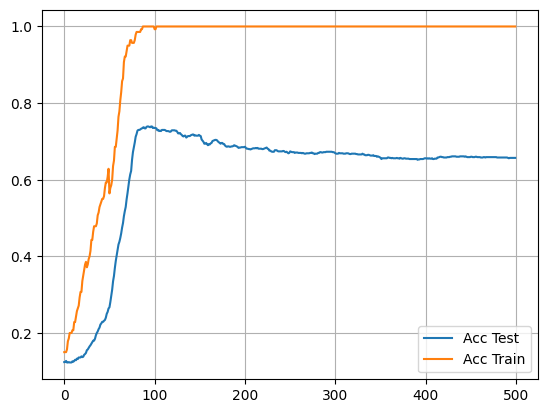

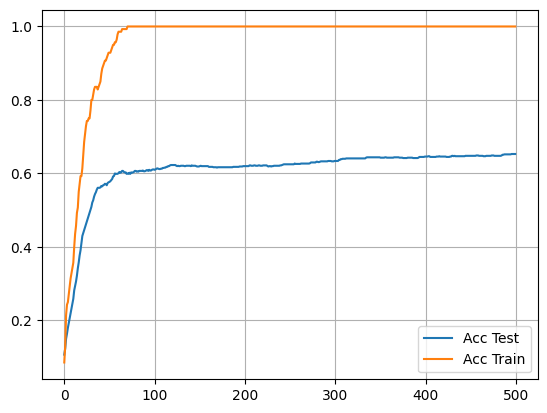

In [6]:
# NOTE: Accuracies only computed in graph filter step
acc_test = accs_test_rgnn1.flatten()
acc_train = accs_train_rgnn1.flatten()

plt.figure()
plt.plot(acc_test, label='Acc Test')
plt.plot(acc_train, label='Acc Train')
plt.legend()
plt.grid()
# LOSS?

acc_test = accs_test_rgnn2.flatten()
acc_train = accs_train_rgnn2.flatten()

plt.figure()
plt.plot(acc_test, label='Acc Test')
plt.plot(acc_train, label='Acc Train')
plt.legend()
plt.grid()
# LOSS?


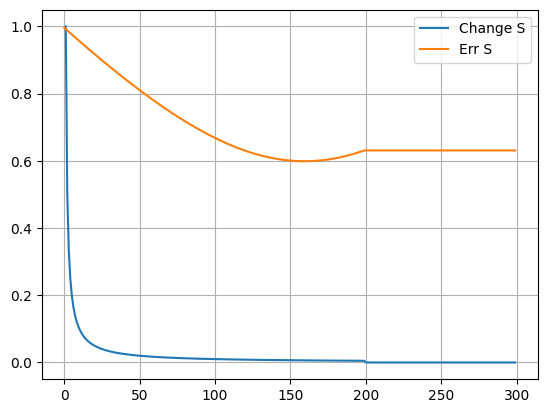

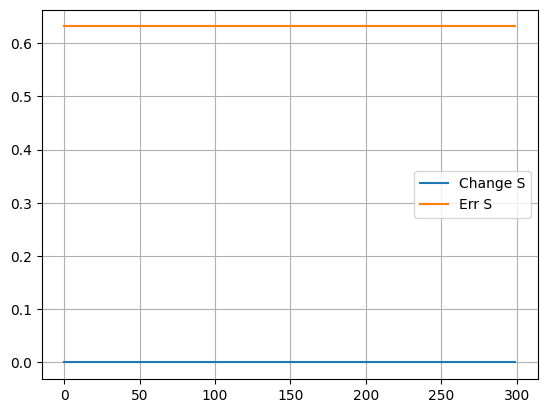

In [7]:
change_S = change_S_rgnn1.flatten()
err_S = errs_S_rgnn1.flatten()

plt.figure()
plt.plot(change_S, label='Change S')
plt.plot(err_S, label='Err S')
plt.legend()
plt.grid()


change_S = change_S_rgnn2.flatten()
err_S = errs_S_rgnn2.flatten()

plt.figure()
plt.plot(change_S, label='Change S')
plt.plot(err_S, label='Err S')
plt.legend()
plt.grid()